In [1]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import EstimatorV2 as Estimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = LinAlgAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Got DMRG energy -6.46410e+00

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[241]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [241]
Initial energy: -3.0
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685638066
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [79]
Initial energy: -4.23606797749979
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743589121112), np.float64(0.0)]

Current energy: -6.0
(change of -1.7639320225002102)
Cur

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170890328
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630400079)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821384
Optimizing energy with indices [241, 79, 228, 210, 201]...
Starting point: [np.float64(-0.7853981583988792), np.float64(0.7853981546000974), np.float64(0.16356985600597426), np.float64(0.16356985910794808), np.float64(0.0)]

Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [241, 79, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 4.304596930583723e-08

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indic

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.4641016151377535
(change of -0.13682546031637077)
Current ansatz: [244, 26, 198, 177, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.4641016151377535
Error: 2.6645352591003757e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 26, 198, 177, 216]
Coefficients: [np.float64(0.7853981633974515), np.float64(0.7853981633974543), np.float64(-0.16991845472706288), np.float64(0.13089969389957487), np.float64(-0.1308996938995742)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031637077)
Current ansatz: [244, 79, 228, 120, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 120, 201]
Coefficients: [np.float64(0.785398163397446), np.float64(0.7853981633974514), np.float64(0.13089969389957493), np.float64(0.16991845472706057), np.float64(0.13089969389957426)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170755775
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 228, 210, 201]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [244, 79, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170755775
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 228, 210, 201]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637166)
Current ansatz: [244, 79, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.2041705292037248)
Current ansatz: [228, 26, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962170890328
Operators under consideration (1):
[141]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916304000817)]
Operator(s) added to ansatz: [141]
Initial energy: -6.327276154821384
Optimizing energy with indices [228, 26, 225, 147, 141]...
Starting point: [np.float64(-0.7853981583988835), np.float64(0.7853981546000937), np.float64(-0.16356985600597373), np.float64(-0.16356985910794838), np.float64(0.0)]

Current energy: -6.464101615137757
(change of -0.13682546031637344)
Current ansatz: [228, 26, 225, 147, 141]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137757
Error: -8.881784197001252e-16
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz i

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [241, 79, 225, 210, 198]
Performing final convergence check...
Total gradient norm: 1.3792097953629424e-07

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [241, 79, 225, 210, 198]
Coefficients: [np.float64(-0.7853981639041918), np.float64(0.7853981615956298), np.float64(-0.16991845431483457), np.float64(0.13089969399906354), np.float64(-0.13089969115024044)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[211]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [211]
Initial energy: -3.0
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.82842712474619
(change of -0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821384
(change of -0.20417052920372303)
Current ansatz: [211, 241, 74, 228, 135]
Performing final convergence check...
Total gradient norm: 6.240962168586195

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917526562089067 > 1e-05)

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685638066
Operators under consideration (1):
[7

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031637255)
Current ansatz: [210, 225, 31, 225, 147]
Performing final convergence check...
Total gradient norm: 7.86010602471275e-08

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [210, 225, 31, 225, 147]
Coefficients: [np.float64(0.13089969389712924), np.float64(0.7853981665051644), np.float64(-0.7853981673219859), np.float64(-0.16991845473543282), np.float64(-0.13089969394980838)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[177]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [177]
Initial energy: -3.0
Optimizing energy with indices [177]...
Starting point: [np.float64(0.0)]

Current energy: -4.2360679774997

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137754
(change of -0.13682546031637166)
Current ansatz: [177, 74, 228, 198, 216]
Performing final convergence check...
Total gradient norm: 3.1544650425023313e-07

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [177, 74, 228, 198, 216]
Coefficients: [np.float64(-0.7853981593401244), np.float64(-0.7853981493607413), np.float64(0.13089969397486864), np.float64(-0.1699184550541404), np.float64(-0.13089969095908266)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962170895283
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630383289)]
Operator(s) added to ansatz: [156]
Initial energy: -6.327276154821385
Optimizing energy with indices [244, 74, 228, 210, 156]...
Starting point: [np.float64(0.7853981583376403), np.float64(-0.7853981546248201), np.float64(0.16356985600946497), np.float64(0.1635698591058963), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 74, 228, 210, 156]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 74, 228, 210, 156]
Coefficients: [np.float64(0.7853981633669305), np.float64(-0.785398163371848), np.float64(0.13089969389737208), np.float64(0.16991845477892947), np.float64(0.13089969390221307)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [244, 74, 228, 198, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 74, 228, 198, 216]
Coefficients: [np.float64(0.78539816332603), np.float64(-0.7853981632570066), np.float64(0.13089969388333836), np.float64(-0.16991845478907364), np.float64(-0.13089969433623952)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Cu

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031637077)
Current ansatz: [244, 79, 228, 120, 156]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 120, 156]
Coefficients: [np.float64(0.785398163397446), np.float64(0.7853981633974514), np.float64(0.13089969389957493), np.float64(0.16991845472706057), np.float64(0.13089969389957426)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 31, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 31, 228, 210, 201]
Coefficients: [np.float64(0.7853981633669305), np.float64(-0.785398163371848), np.float64(0.13089969389737208), np.float64(0.16991845477892947), np.float64(0.13089969390221307)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[241]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [241]
Initial energy: -3.0
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685638066
Operators under consideration (1):
[74]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [74]
Initial energy: -4.23606797749979
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743589121112), np.float64(0.0)]

Current energy: -6.0
(change of -1.7639320225002102)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [244, 74, 228, 147, 216]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 74, 228, 147, 216]
Coefficients: [np.float64(0.78539816332603), np.float64(-0.7853981632570066), np.float64(0.13089969388333836), np.float64(-0.16991845478907364), np.float64(-0.13089969433623952)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[241]
Corresponding gradients (ordered by magnitude):
[np.float64(4.0)]
Operator(s) added to ansatz: [241]
Initial energy: -3.0
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749979
(change of -1.2360679774997898)
Cur

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137757
(change of -0.13682546031637433)
Current ansatz: [241, 79, 228, 198, 216]
Performing final convergence check...
Total gradient norm: 4.011223017551011e-07

Convergence condition achieved!

Final Energy: -6.464101615137757
Error: -8.881784197001252e-16
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz indices: [241, 79, 228, 198, 216]
Coefficients: [np.float64(-0.7853981737163428), np.float64(0.7853981611746695), np.float64(0.1308996938408419), np.float64(-0.16991845809379405), np.float64(-0.13089969135928972)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.2360679774

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137757
(change of -0.13682546031637433)
Current ansatz: [244, 31, 225, 210, 201]
Performing final convergence check...
Total gradient norm: 4.011223017551011e-07

Convergence condition achieved!

Final Energy: -6.464101615137757
Error: -8.881784197001252e-16
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz indices: [244, 31, 225, 210, 201]
Coefficients: [np.float64(0.7853981737163428), np.float64(-0.7853981611746695), np.float64(-0.1308996938408419), np.float64(0.16991845809379405), np.float64(0.13089969135928972)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962170895283
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491630383289)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821385
Optimizing energy with indices [244, 31, 228, 210, 201]...
Starting point: [np.float64(0.7853981583376403), np.float64(-0.7853981546248201), np.float64(0.16356985600946497), np.float64(0.1635698591058963), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031636988)
Current ansatz: [244, 31, 228, 210, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 31, 228, 210, 201]
Coefficients: [np.float64(0.7853981633669305), np.float64(-0.785398163371848), np.float64(0.13089969389737208), np.float64(0.16991845477892947), np.float64(0.13089969390221307)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962174378714
Operators under consideration (1):
[108]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916185785894)]
Operator(s) added to ansatz: [108]
Initial energy: -6.327276154821382
Optimizing energy with indices [244, 79, 216, 225, 108]...
Starting point: [np.float64(0.7853981467683384), np.float64(0.7853981446408085), np.float64(-0.16356985846360111), np.float64(-0.16356985766358637), np.float64(0.0)]

Current energy: -6.464101615137754
(change of -0.13682546031637255)
Current ansatz: [244, 79, 216, 225, 108]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 216, 225, 108]
Coefficients: [np.float64(0.7853981633974689), np.float64(0.7853981633975026), np.float64(-0.1308996938995775), np.float64(-0.1699184547270645), np.float64(-0.13089969389956

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.1231056256176615
(change of -0.12310562561766059)
Current ansatz: [211, 244, 79, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526562358736
Operators under consideration (1):
[180]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850712496991756)]
Operator(s) added to ansatz: [180]
Initial energy: -6.1231056256176615
Optimizing energy with indices [211, 244, 79, 216, 180]...
Starting point: [np.float64(1.911144406282647e-09), np.float64(0.7853981681973516), np.float64(0.7853981649193256), np.float64(-0.12248933146718585), np.float64(0.0)]

Current energy: -6.327276154821382
(change of -0.20417052920372036)
Current ansatz: [211, 244, 79, 216, 180]
Performing final convergence check...
Total gradient norm: 6.240962167241899

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917526562358736 > 1e-05)

I

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154821382
(change of -0.20417052920372214)
Current ansatz: [244, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962174378714
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491622806943)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154821382
Optimizing energy with indices [244, 79, 216, 225, 201]...
Starting point: [np.float64(0.7853981467683384), np.float64(0.7853981446408085), np.float64(-0.16356985846360111), np.float64(-0.16356985766358637), np.float64(0.0)]

Current energy: -6.464101615137755
(change of -0.13682546031637344)
Current ansatz: [244, 79, 216, 225, 201]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137755
Error: 8.881784197001252e-16
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz ind

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615137757
(change of -0.1368254603163761)
Current ansatz: [244, 79, 228, 108, 210]
Performing final convergence check...
Total gradient norm: 1.0497567231426676e-07

Convergence condition achieved!

Final Energy: -6.464101615137757
Error: -8.881784197001252e-16
(in % of chemical accuracy: -0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 108, 210]
Coefficients: [np.float64(0.7853981635146439), np.float64(0.7853981625524754), np.float64(0.16991845440362235), np.float64(-0.13089969398073778), np.float64(0.13089969163627527)]

Initial energy: -3.0

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265423
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.0)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.23606797749

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962170755775
Operators under consideration (1):
[54]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.08949163023728)]
Operator(s) added to ansatz: [54]
Initial energy: -6.327276154821384
Optimizing energy with indices [244, 79, 228, 210, 54]...
Starting point: [np.float64(0.7853981591884951), np.float64(0.7853981561770126), np.float64(0.163569856028253), np.float64(0.16356985904658614), np.float64(0.0)]

Current energy: -6.464101615137756
(change of -0.13682546031637255)
Current ansatz: [244, 79, 228, 210, 54]
Performing final convergence check...
Total gradient norm: 0.0

Convergence condition achieved!

Final Energy: -6.464101615137756
Error: 0.0
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [244, 79, 228, 210, 54]
Coefficients: [np.float64(0.7853981633972894), np.float64(0.7853981633977053), np.float64(0.1308996938995724), np.float64(0.1699184547272141), np.float64(0.13089969389958706)]

Initial energy: -3.0

***

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.24096217011076
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916295803867)]
Operator(s) added to ansatz: [156]
Initial energy: -6.327276154821383
Optimizing energy with indices [225, 79, 225, 210, 156]...
Starting point: [np.float64(0.7853981631481891), np.float64(0.7853981632876346), np.float64(-0.16356985611168007), np.float64(0.16356985877580135), np.float64(0.0)]

Current energy: -6.464101615137754
(change of -0.13682546031637166)
Current ansatz: [225, 79, 225, 210, 156]
Performing final convergence check...
Total gradient norm: 3.154465042502331e-07

Convergence condition achieved!

Final Energy: -6.464101615137754
Error: 1.7763568394002505e-15
(in % of chemical accuracy: 0.000%)
Iterations completed: 5
Ansatz indices: [225, 79, 225, 210, 156]
Coefficients: [np.float64(0.7853981593401244), np.float64(0.7853981493607413), np.float64(-0.13089969397486864), np.float64(0.1699184550541404), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [28]:
# Now go to the larger size.
new_l = 2 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=True,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = LinAlgAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(10):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=True)
    # circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -1.34997e+01
Tiled pool has 91 operators.

linalg_adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -7.0
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.0
Operator 1: -4.0
Operator 2: 4.0
Operator 3: -4.0
Operator 4: 4.0
Operator 5: -4.0
Operator 6: 4.0
Operator 7: -4.0
Operator 8: 4.0
Operator 9: -4.0
Operator 10: 4.0
Operator 11: 4.0
Operator 12: 4.0
Operator 13: 4.0
Operator 14: 4.0
Operator 15: -4.0
Operator 16: -4.0
Operator 17: -4.0
Operator 18: -4.0
Operator 19: -4.0
Operator 25: 4.0
Operator 26: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [29]:
for circuit in circuits:
    print(circuit.depth())

10
19
26
33
42
47
54
59
64
71


In [30]:
print(circuits[0])

           ┌───┐                                                           »
 q30_0: ───┤ H ├─────■──────────────────────────────────────────────■──────»
        ┌──┴───┴──┐┌─┴─┐                                          ┌─┴─┐    »
 q30_1: ┤ Rx(π/2) ├┤ X ├──■─────────────────────────────■─────────┤ X ├────»
        ├─────────┤└───┘┌─┴─┐                         ┌─┴─┐    ┌──┴───┴───┐»
 q30_2: ┤ Rx(π/2) ├─────┤ X ├──■────────────────■─────┤ X ├────┤ Rx(-π/2) ├»
        ├─────────┤     └───┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴───┐└──────────┘»
 q30_3: ┤ Rx(π/2) ├──────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rx(-π/2) ├────────────»
        └─────────┘          └───┘└──────────┘└───┘└──────────┘            »
 q30_4: ───────────────────────────────────────────────────────────────────»
                                                                           »
 q30_5: ───────────────────────────────────────────────────────────────────»
                                                                           »

Text(0, 0.5, 'Energy error')

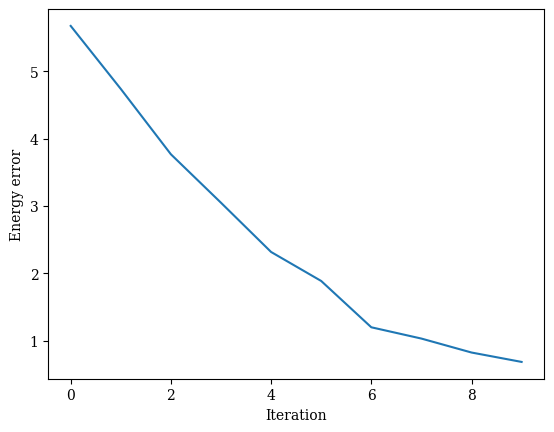

In [31]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [32]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Simulate noiseless and noisy ADAPT circuits

In [33]:
noiseless_ckt_energies = []
for circuit in circuits:
    exact_estimator = Estimator()
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, AerSimulator())
    isa_circuit = pass_manager.run(circuit)
    pub = (isa_circuit, h_qiskit)
    job = exact_estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    noiseless_ckt_energies.append(exact_value)

noiseless_ckt_errs = np.abs(np.array(noiseless_ckt_energies) - exact_energy)

Text(0.5, 1.0, 'Energy error from ADAPT circuits.')

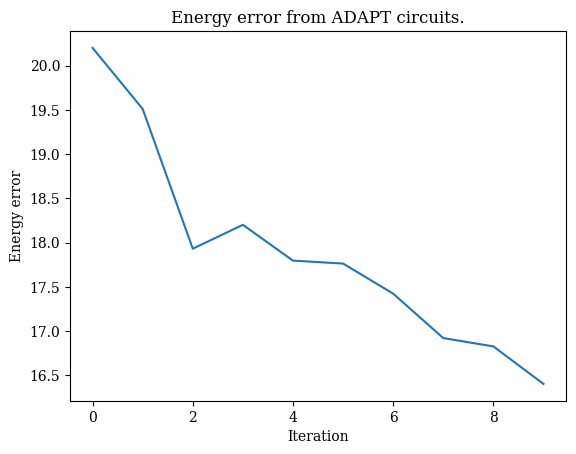

In [34]:
fig, ax = plt.subplots()
ax.plot(noiseless_ckt_errs)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.set_title("Energy error from ADAPT circuits.")

## Carry out SQD.

In [30]:
# Use a fake computer to get noise.
computer = qiskit_ibm_runtime.fake_provider.FakeTorino()
simualtor = AerSimulator(method="matrix_product_state").from_backend(computer)
sampler = Sampler(simualtor)

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [32]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'rz': 11, 'sx': 10, 'measure': 8, 'cz': 7, 'x': 5, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 23, 'sx': 23, 'cz': 14, 'x': 8, 'measure': 8, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 34, 'rz': 32, 'cz': 21, 'x': 8, 'measure': 8, 'barrier': 4})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 49, 'rz': 46, 'cz': 30, 'measure': 8, 'x': 6, 'barrier': 5})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 63, 'rz': 62, 'cz': 36, 'x': 9, 'measure': 8, 'barrier': 6})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 73, 'rz': 72, 'cz': 40, 'x': 8, 'measure': 8, 'barrier': 7})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 86, 'rz': 83, 'cz': 45, 'x': 11, 'barrier': 8, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 100, 'rz': 96, 'cz': 50, 'x': 11, 'barrier': 9, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 99, 'sx': 99, 'cz': 52, 'x': 11, 

In [33]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)


Text(0, 0.5, 'Energy error')

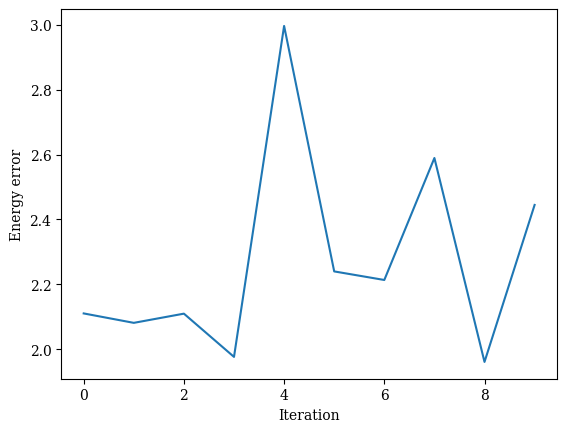

In [34]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [35]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

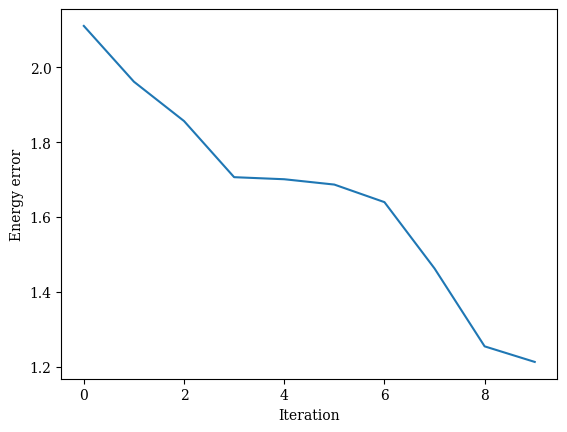

In [36]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Random sampling

Instead of sampling from an approximation of the ground state, make a truly random array of bits.

In [37]:
from qiskit_addon_sqd.counts import generate_bit_array_uniform

bit_array = generate_bit_array_uniform(30_000, nq, rand_seed=1)

In [38]:
bit_matrix = bit_array.to_bool_array()
eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
min_energy_random = np.min(eigvals)
err_random = abs(min_energy - exact_energy)
rel_err_random = err_random / abs(exact_energy)

## Plot final results

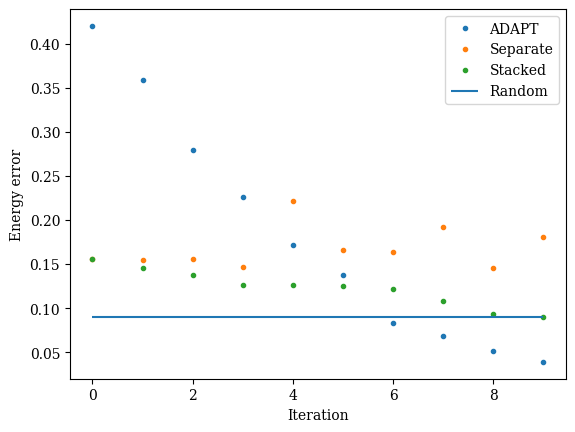

In [39]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.hlines(rel_err_random, 0., len(rel_errors) - 1, label="Random")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()